# Pokemon - Base Stats and Types
**Description:** Is there a correlation between a Pokemon's Defense stat and it's weight?

**Goal:** To determine whether or not Defense and Weight in the Pokemon universe are related. 

<img src="https://github.com/Mushtatoes/proj/blob/master/pikachu.png?raw=true" width="300"/>


---
Defense is one of the primary stats used during combat in Pokemon. It has to adhere to the GameFreak's decisions on gameplay purposes and balancing changes.
Weight is less important in the actual gameplay, and moreso there as a fun fact in the Pokedex entry. It's highly unlikely that developers look at Defense and Weight in parallel when creating Pokemon.

There are Pokemon like Onix and Steelix, both of which have positively correlated Defense and Weight, but then there are Pokemon like Shuckle...a tiny and light Pokemon with even higher Defense than the two mentioned.

This study will calculate the correlation coefficient between Defense and Weight and determine what kind of relationship the two properties have.




In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re

## 1. Obtaining Data


>- No mega-evolutions, alternate forms, etc.
- Pulling from PokeAPI
- Manually parse and add data into Dataframe without using read_json
- At time of writing, there are currently 807 unique Pokemon in the API (Up to Gen 7)




In [0]:
pokemon_json = requests.get('https://pokeapi.co/api/v2/pokemon?&limit=5000').json()
# print(pokemon_json)

#### 1a. Filter out non-standard Pokemon by id:
>- Create a list of urls that can be used to pull data on each Pokemon.
- PokeAPI uses id <= 10000 to identify standard Pokemon and their traits.
- Use regular expressions to isolate the id from the url and compare.

In [0]:
name_url_raw = pokemon_json['results']

# Filter out non-standard Pokemon using regex on url:
def pokemon_filter(pokemon_object):
  pokemon_search = re.search('^https://pokeapi\.co/api/v2/pokemon/(\d+)/$', pokemon_object['url'])
  if not pokemon_search:
    return False
  return int(pokemon_search.group(1)) <= 10000

name_url = list(filter(pokemon_filter, name_url_raw))

pokemon_urls = [x['url'] for x in name_url]


#### 1b. Map the required data:
>- Each Pokemon's base stats can only be found on their own page, which means a request for each Pokemon.
- Storing into a flat file or SQL table would be preferable if the data is  required for reuse in the future.

In [0]:
# Return each pokemon's name, type1, and base stats:
def pokemon_map(url):
  pokemon = requests.get(url).json()
  data = {'name': pokemon['name']
          ,'type1': ''.join([t['type']['name'] for t in pokemon['types'] if t['slot'] == 1])
          ,'stats': {s['stat']['name']: s['base_stat']for s in pokemon['stats']}
          ,'weight': pokemon['weight']
          }
  return data

# Type1 and stats are not required here: pulled in the case this data needs to be re-used for other tests 
pokemon_data = list(map(pokemon_map, pokemon_urls))

#print(pokemon_data)

#### 1c. Push the data into a pandas DataFrame:
> - Pokemon weight stored in PokeAPI is in kg/10 (Bulbsaur = 69 --> 6.9kg)
- Name, DEF and Weight will be stored into separate lists and then pushed into the DataFrame.

In [5]:
# Format data into dictionaries for DataFrame:
# {Header: [data]}

def pivot_data(category, subcategory = None):
  if not subcategory:
    return [pokemon[category] for pokemon in pokemon_data]
  else:
    return [pokemon[category][subcategory] for pokemon in pokemon_data]

pokemon_name = pivot_data('name')
pokemon_def = pivot_data('stats', 'defense')
pokemon_weight = pivot_data('weight')

pokemon_df = pd.DataFrame({'Name': pokemon_name
                           ,'DEF': pokemon_def
                           ,'Weight': pokemon_weight
                           })

# Display top rows from DataFrame for preview:

pokemon_df.head()

,Name,DEF,Weight
0,bulbasaur,49,69
1,ivysaur,63,130
2,venusaur,83,1000
3,charmander,43,85
4,charmeleon,58,190


## 2. Testing the Relationship



#### 2a. Viewing and Standardizing the Data
>- Calculate the correlation coefficient between DEF and Weight.
- Return value between -1 (move oppositely) and +1 (move together)

Let's see how the data looks on a quick plot:


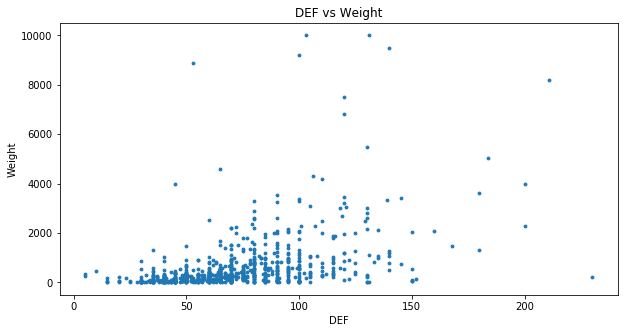

In [11]:
x = pokemon_df.DEF
y = pokemon_df.Weight

plt.figure(figsize = (10,5))

fig = plt.scatter(x, y, s = 8)

plt.title('DEF vs Weight')
plt.xlabel('DEF')
plt.ylabel('Weight')

plt.show()

The graph above shows that the range for Weight is on a much greater scale than the range for DEF. 

Since the scaling is so different, it would be beneficial to standardize the data:



In [13]:
# Calculate mean and standard deviation using DataFrame methods:
def_mu = pokemon_df.DEF.mean()
def_sig = pokemon_df.DEF.std()

weight_mu = pokemon_df.Weight.mean()
weight_sig = pokemon_df.Weight.std()

# Create z-score columns in pokemon_df:


print(DEF_mu, DEF_sig)
print(weight_mu, weight_sig)

71.72614622057002 29.73022787537992
617.7112763320941 1115.1935536904728
